In [266]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [267]:
df = pd.read_csv('../CSV Files/df_ufc_masters_w_reversed.csv')

In [268]:
features = [
    'B_avg_SIG_STR_landed',
    'B_avg_SIG_STR_pct',
    'B_avg_SUB_ATT',
    'B_avg_TD_landed',
    'B_avg_TD_pct',
    'R_avg_SIG_STR_landed',
    'R_avg_SIG_STR_pct',
    'R_avg_SUB_ATT',
    'R_avg_TD_landed',
    'R_avg_TD_pct',
    'B_Height_cms',
    'B_Reach_cms',
    'R_Height_cms',
    'R_Reach_cms', 
    'R_age',
    'B_age'
]

# List of columns to apply np.log
columns_to_log = ['B_avg_SIG_STR_landed', 'B_avg_SUB_ATT', 'B_avg_TD_landed', 
                  'R_avg_SIG_STR_landed', 'R_avg_SUB_ATT', 'R_avg_TD_landed']

# Applying np.log to each column in the list
for col in columns_to_log:
    # Adding a small constant to avoid log(0) which is undefined
    df[col] = np.log(df[col] + 1e-5)


In [269]:
df['date'] = pd.to_datetime(df['date'])

In [270]:
type(df['date'])

pandas.core.series.Series

In [271]:
train_end_date = '2020-09-05'
test_start_date = '2020-09-06'

In [272]:
df_train = df[(df['date'] <= train_end_date)]
df_test = df[(df['date'] >= test_start_date)]

In [273]:
X_train =df_train[features]
y_train= df_train['Winner']

In [274]:
X_test =df_test[features]
y_test= df_test['Winner']

In [275]:
y_encoded = y_train.apply(lambda x: 1 if x == 'Red' else 0)
y_encoded = y_test.apply(lambda x: 1 if x == 'Red' else 0)

In [276]:
sScaler = StandardScaler()
X_train_scaled = sScaler.fit_transform(X_train)
X_test_scaled = sScaler.transform(X_test)

In [277]:
random_forest_model = RandomForestClassifier(n_estimators=50,max_depth=3,min_samples_split=5, random_state=42)
random_forest_model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=3, min_samples_split=5, n_estimators=50,
                       random_state=42)

In [278]:
y_pred_test = random_forest_model.predict(X_test_scaled)
y_pred_train = random_forest_model.predict(X_train_scaled)

In [279]:
y_pred_percent= random_forest_model.predict_proba(X_test_scaled)

In [280]:
y_pred_proba_df = pd.DataFrame(y_pred_percent, columns=['Probability_Blue', 'Probability_Red'])
result_df = pd.concat([df_test, y_pred_proba_df], axis=1)

In [281]:
result_df=result_df[['R_fighter', 'B_fighter', 'Winner', 'R_odds', 'B_odds','R_ev', 'B_ev', 'Probability_Blue', 'Probability_Red']].copy().dropna()

In [282]:
#B_ev * Prob Blue - Prob Red*100>0
#lage graf for ideele treshold
#hvor mye penger

In [283]:
condition_blue = (result_df['B_ev'] * result_df['Probability_Blue']-100*result_df['Probability_Red']) > 10
condition_red = (result_df['R_ev'] * result_df['Probability_Red'] - 100*result_df['Probability_Blue']) > 10

In [284]:
bank=0
for index, row in result_df.iterrows():
    if condition_blue[index]:
        bet_amount = 100  
        
        if row['Winner'] == 'Blue':
            #bank +=1
            bank += row['B_ev'] * (bet_amount / 100)
        else:
            bank -= bet_amount
        print(f"Who Win: {row['Winner']}, Blue price: {row['B_ev']}, Win prob: {row['Probability_Blue']}")

    elif condition_red[index]:
        bet_amount = 1  
        
        if row['Winner'] == 'Red':
            #bank +=1
            bank += row['B_ev'] * (bet_amount / 100)
        else:
            bank -= bet_amount
        print(f"Who Win: {row['Winner']}, Red price: {row['R_ev']}, Win prob: {row['Probability_Red']}")

print(bank)

Who Win: Red, Blue price: 130.0, Win prob: 0.5683978022773496
Who Win: Blue, Red price: 170.0, Win prob: 0.5186638229016125
Who Win: Blue, Red price: 110.0, Win prob: 0.5282632413415882
Who Win: Red, Blue price: 475.0, Win prob: 0.4622172963566202
Who Win: Blue, Red price: 215.0, Win prob: 0.42982534618530344
Who Win: Blue, Red price: 500.0, Win prob: 0.4285284219092594
Who Win: Blue, Blue price: 135.0, Win prob: 0.5170190718743871
Who Win: Red, Blue price: 225.0, Win prob: 0.5599443556888096
Who Win: Red, Blue price: 135.0, Win prob: 0.5097955964507618
Who Win: Red, Blue price: 235.0, Win prob: 0.4931316246800339
Who Win: Red, Blue price: 155.0, Win prob: 0.49363247901620544
Who Win: Red, Blue price: 800.0, Win prob: 0.46053129342431853
Who Win: Blue, Red price: 140.0, Win prob: 0.5018264251969037
Who Win: Red, Blue price: 290.0, Win prob: 0.4087167174672351
Who Win: Red, Blue price: 180.0, Win prob: 0.46313958863194865
Who Win: Blue, Red price: 245.0, Win prob: 0.4594880857906307
Who

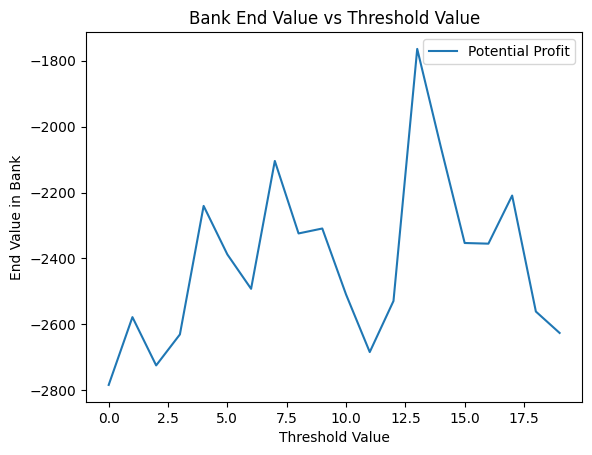

In [285]:
# Assuming result_df is your DataFrame
# Initialize bank to 0
bank = 0

# List of threshold values to test
threshold_values = range(0, 20)  # Adjust the range as needed

# Lists to store results
end_value = []

for threshold in threshold_values:
    condition_blue = (result_df['B_ev'] * result_df['Probability_Blue'] - 100 * result_df['Probability_Red']) > threshold
    condition_red = (result_df['R_ev'] * result_df['Probability_Red'] - 100 * result_df['Probability_Blue']) > threshold

    bank = 0  # Reset bank for each threshold value

    for index, row in result_df.iterrows():
        if condition_blue[index]:
            bet_amount = 100

            if row['Winner'] == 'Blue':
                bank += row['B_ev'] * (bet_amount / 100)
            else:
                bank -= bet_amount

        elif condition_red[index]:
            if row['Winner'] == 'Red':
                bank += row['R_ev'] * (bet_amount / 100)
            else:
                bank -= bet_amount

    end_value.append(bank if condition_blue.any() else 0)

    max_index = end_value.index(max(end_value))
    max_threshold = list(threshold_values)[max_index]
    max_value = max(end_value)

# Plotting the results
plt.plot(threshold_values, end_value, label='Potential Profit')
plt.xlabel('Threshold Value')
plt.ylabel('End Value in Bank')
plt.legend()
plt.title('Bank End Value vs Threshold Value')
plt.show()

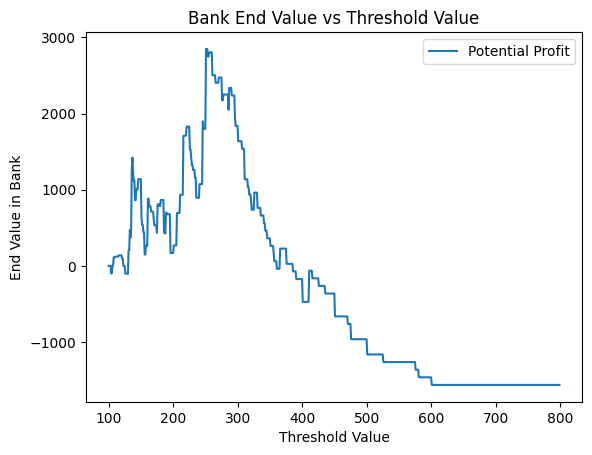

In [286]:
# Assuming result_df is your DataFrame
# Initialize bank to 0
bank = 0

# List of threshold values to test
threshold_values = range(100, 800)  # Adjust the range as needed

# Lists to store results
end_value = []

for threshold in threshold_values:
    condition_blue = ((result_df['B_ev'] * result_df['Probability_Blue'] - 100 * result_df['Probability_Red']) > max_index) & (result_df['B_ev']<threshold)
    condition_red = ((result_df['R_ev'] * result_df['Probability_Red'] - 100 * result_df['Probability_Blue']) > max_index) & (result_df['R_ev']<threshold)

    bank = 0  # Reset bank for each threshold value

    for index, row in result_df.iterrows():
        if condition_blue[index]:
            bet_amount = 100

            if row['Winner'] == 'Blue':
                bank += row['B_ev'] * (bet_amount / 100)
            else:
                bank -= bet_amount

        elif condition_red[index]:

            if row['Winner'] == 'Red':
                bank += row['R_ev'] * (bet_amount / 100)
            else:
                bank -= bet_amount

    end_value.append(bank if condition_blue.any() else 0)

# Plotting the results
plt.plot(threshold_values, end_value, label='Potential Profit')
plt.xlabel('Threshold Value')
plt.ylabel('End Value in Bank')
plt.legend()
plt.title('Bank End Value vs Threshold Value')
plt.show()

In [287]:
end_value

[0,
 0,
 0,
 0,
 -100,
 -100,
 5.0,
 5.0,
 112.0,
 112.0,
 112.0,
 122.0,
 122.0,
 122.0,
 122.0,
 122.0,
 137.0,
 137.0,
 137.0,
 137.0,
 137.0,
 97.0,
 97.0,
 -3.0,
 -3.0,
 -3.0,
 -103.0,
 -103.0,
 -103.0,
 -103.0,
 -103.0,
 207.0,
 207.0,
 471.0,
 371.0,
 505.0,
 1285.0,
 1421.0,
 1221.0,
 1121.0,
 1121.0,
 861.0,
 861.0,
 1003.0,
 1003.0,
 1003.0,
 1138.0,
 1138.0,
 1138.0,
 1138.0,
 1138.0,
 638.0,
 538.0,
 538.0,
 438.0,
 438.0,
 148.0,
 148.0,
 262.0,
 262.0,
 262.0,
 882.0,
 882.0,
 782.0,
 782.0,
 782.0,
 712.0,
 712.0,
 712.0,
 712.0,
 612.0,
 532.0,
 532.0,
 532.0,
 532.0,
 432.0,
 807.0,
 807.0,
 807.0,
 785.0,
 785.0,
 865.0,
 865.0,
 865.0,
 865.0,
 865.0,
 435.0,
 435.0,
 422.0,
 698.0,
 698.0,
 678.0,
 678.0,
 678.0,
 678.0,
 678.0,
 168.0,
 168.0,
 168.0,
 168.0,
 168.0,
 268.0,
 268.0,
 268.0,
 268.0,
 268.0,
 693.0,
 693.0,
 693.0,
 693.0,
 693.0,
 933.0,
 933.0,
 933.0,
 933.0,
 933.0,
 1708.0,
 1708.0,
 1708.0,
 1708.0,
 1708.0,
 1828.0,
 1828.0,
 1828.0,
 1828.0,


In [288]:
accuracy = accuracy_score(y_train, y_pred_train)
conf_matrix = confusion_matrix(y_train, y_pred_train)
classification_rep = classification_report(y_train, y_pred_train)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

Accuracy: 0.5956
Confusion Matrix:
 [[2602 1760]
 [1768 2594]]
Classification Report:
               precision    recall  f1-score   support

        Blue       0.60      0.60      0.60      4362
         Red       0.60      0.59      0.60      4362

    accuracy                           0.60      8724
   macro avg       0.60      0.60      0.60      8724
weighted avg       0.60      0.60      0.60      8724



In [289]:
accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
classification_rep = classification_report(y_test, y_pred_test)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

Accuracy: 0.5846
Confusion Matrix:
 [[323 209]
 [233 299]]
Classification Report:
               precision    recall  f1-score   support

        Blue       0.58      0.61      0.59       532
         Red       0.59      0.56      0.57       532

    accuracy                           0.58      1064
   macro avg       0.58      0.58      0.58      1064
weighted avg       0.58      0.58      0.58      1064

